In [613]:
import numpy as np
import matplotlib.pyplot as plt
import math

from dataclasses import dataclass

In [614]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


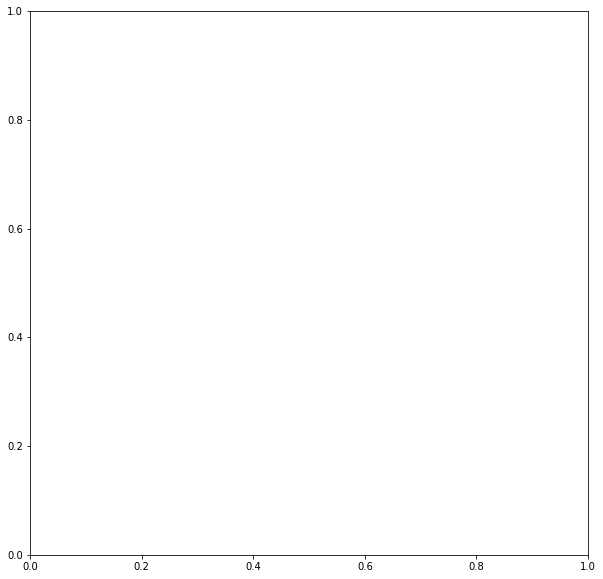

In [615]:
from celluloid import Camera
fig, ax = plt.subplots(figsize=(10,10));
camera = Camera(fig);

In [616]:
#Здесь будут константы
v0 = 0                                                      #начальная скорость всех звеньев
m = 1                                                       #масса звеньев
g = 9.81
kk = 250                                                      #линейная жесткость пружин


b = 0.1                                                       
iters = 1000

n = 35
r = 0.1 #радиус частичек. ???? не использую
p = 1     # расстояние м-ду крайними закреплениями поинтов
l = p/(n-1) # длина пружинок 
dt = 0.05*np.sqrt(m)/np.sqrt(kk)

pmax =l*(n-1)      #максимальное расстояние между 2-мя закреплениями поинтов

ball_y = 0
ball_v = 0
t_fall = math.sqrt(2*pmax/g) #?????
t = 0
tmax = 0;

NUMP = n                                                   #количество звеньев = (2n+1) - параметр n подается дли создания равномерных звеньев
NUMS = NUMP-1                                               #количество пружинок


In [617]:
dt = 0.01

In [618]:
l

0.029411764705882353

In [619]:
pmax

1.0

In [620]:
@dataclass
class point:
    x : float
    y : float
    vx : float
    vy : float
    fx : float
    fy : float
    vp: float           # скорость пред
    ay: float           # ускорение 
    amax: float         # максимальное ускорение
    indexx: float       # шаг по времени максимального ускорения
@dataclass
class spring:
    fx : float
    fy : float

In [621]:
points = [None] * (NUMP+1)
springs = [None] * (NUMS+1)
px = []
py = []
px0 = 0
pxl = 0
py0 = 0
pyl = 0

In [622]:
def start_coordinates(n):
  dx = p/(n-1)
  for i in range(n):
    px.append(i*dx)
    py.append(0)
  px.append((n+5)*dx)
  py.append(0)

In [623]:
start_coordinates(n)

In [624]:
pxl = px[n-1]
px0 = px[0]
pyl = py[n-1]
py0 = py[0]

In [625]:
#Создание цепи в начальном положении
def CreateChain():
    for i in range(NUMP+1):
        points[i] = point(px[i],py[i] , v0, v0, 0, 0, 0, 0, 0, 0)
    for i in range(NUMS):
        AddSpring(i, i, i + 1)

In [626]:
#создание пружинок
def AddSpring(pi, i, j):
    springs[pi] = spring( 0, 0)

In [627]:
def AccumulateForces():
    #задаю нулевые силы 
    for i in range(NUMP):
        points[i].fx = 0.0
        points[i].fy = 0.0

    #Вычисляю силы, действующие на поинты
    for i in range(NUMP-1):
        x1 = points[i].x
        y1 = points[i].y
        x2 = points[i+1].x
        y2 = points[i+1].y

        r12d = np.sqrt((x2 - x1)**2  +  (y2 - y1)**2)                   #рассчет длины вектора между 2-мя поинтами

        if r12d != 0:
            springs[i].fx = kk*(r12d-l)*((x2 - x1)/(l*r12d)) #проекция сил упругости на Х
            springs[i].fу = kk*(r12d-l)*((y2 - y1)/(l*r12d)) #проекция сил упругости на У
          
            # расписываю силы, действущие на поинты: упругость пружинок и сила тяжести по У
            points[i].fx += springs[i].fx 
            points[i].fy += (springs[i].fу - m*g)
            points[i+1].fx -= (springs[i].fx)
            points[i+1].fy -= (springs[i].fу)

    points[NUMP-1].fy -= m*g   #нужно отнять силу тяжести от последнего звена, т.к. в предыдущем цикле до него не дошли

In [628]:
y_spring = [] #собираю массив у крайнего звена цепочки, чтобы потом построить график y(x)
time = []  #собираю массив времени, в которое падает цепочка
x_spring = [] #собираю массив x у крайнего звена цепочки, чтобы потом построить график y(x)
y_ball = []
x_ball = []
ay_spring = []   # массив ускорения для графика a(t)

In [629]:
def integrate(iterr,t):
    AccumulateForces()

    #расчет скорости
    b = 10
    if iterr>=200:
        b = 0.1

    for i in range (NUMP):
        points[i].vp = np.sqrt(points[i].vy**2+points[i].vx**2) #сохраняем предыдущую скорость по y
        points[i].vx += (points[i].fx/m -b * points[i].vx / m) * dt
        points[i].vy += (points[i].fy/m - b * points[i].vy / m) * dt
        points[0].vx = 0
        points[0].vy = 0
        points[i].ay = np.abs(points[i].vy**2+points[i].vx**2-points[i].vp)/dt #dv/dt. dv счиатется как
        if iterr<200:
            points[NUMP-1].vx = 0
            points[NUMP-1].vy = 0   
        
    
    #расчет нового положения
    for i in range(NUMP):
        points[i].x += (points[i].vx * dt)
        points[i].y += (points[i].vy * dt)
    points[0].x = px0
    points[0].y = py0
    if iterr<200:
        points[NUMP-1].x = pxl
        points[NUMP-1].y = pyl

    #нужно для графиков сравнительных с мячиком
    if iterr >= 200:
        ay_spring.append(points[NUMP-1].ay)#нужно для отрисовки ускорений
        y_spring.append(points[NUMP-1].y)
        x_spring.append(points[NUMP-1].x)
        t+=dt
        time.append(t)
        points[NUMP].y = -g*(t**2)/2      #здесь записываютяс коорды свободно падающего шарика
        y_ball.append(points[NUMP].y)
        x_ball.append(0)

    return t

In [630]:
def DrawChain(iter):
    x = [points[i].x for i in range(NUMP)]
    x = np.array(x)
    y = [points[i].y for i in range(NUMP)]
    y = np.array(y)

    ax.grid()
    ax.plot(x, y, "-ob")
    ax.plot(points[NUMP].x, points[NUMP].y, "or")
    ax.set_ylabel('y(x)')
    ax.set_xlabel('x')
    camera.snap()

In [631]:
def DrawGraphAxel(x,g,t):
    a_spring = x.copy()
    time2 = t.copy()
    g_mas = [g]*len(a_spring)

    plt.grid()
    plt.plot(time2,a_spring, label = 'a_spring')
    plt.plot(time2,g_mas, label = 'g_mas')
    plt.legend(fontsize=14)
    plt.xlabel("t", fontsize=14)
    plt.ylabel('a(t)', fontsize=14)
    plt.show()

In [632]:
def DrawGraph(x,y,z,t):
    y_spring2 = y.copy()
    time2 = t.copy()
    x_spring2 = x.copy()
    y_ball2 = z.copy()
    x_ball2 = np.zeros(len(y_ball2))


    plt.grid()
    plt.plot(x_spring2,y_spring2, label = 'Spring e')
    plt.plot(x_ball2,y_ball2, label = 'Ball')
    plt.legend(fontsize=14)
    plt.xlabel("x", fontsize=14)
    plt.ylabel('y(x)', fontsize=14)
    plt.show()

In [633]:
CreateChain()

t_fall_s = 0
for i in range(iters):
  t_fall_s = integrate(i,t_fall_s)
  if i % 2 == 0: 
      DrawChain(i)
  if points[NUMP-1].x < 0.4:
      break

anim = camera.animate()

from IPython.display import HTML
HTML(anim.to_html5_video())

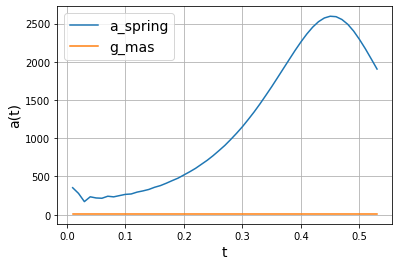

In [586]:
DrawGraphAxel(ay_spring,g,time)

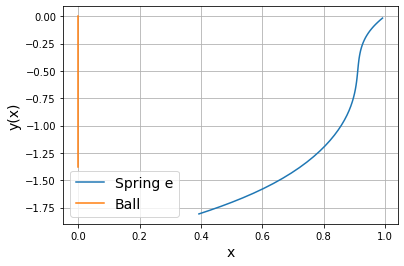

In [587]:
DrawGraph(x_spring,y_spring,y_ball,time)

Посмотрю, во сколько раз цепочка быстрее опускается, чем свободно падающий шарик

In [588]:
# Координата (пройденное расстояние) конца цепочки
y_spring[len(y_spring)-1]

-1.8082434483637577

In [589]:
#Координата (пройденное расстояние) мячика
y_ball[len(y_spring)-1]

-1.3778145000000013

In [590]:
#отношение пройденных путей за одно время
y_ball[len(y_spring)-1]/y_spring[len(y_spring)-1]

0.7619629432346388